# Reconstructing Paleoproterozoic d13C
This notebook can be used to: 
- Load the Paleoproterozoic d13C data and age contraints 
- Build and sample the inference model
- Load the inference results from the model runs used to produce Fig. 2a
- Visualize the results using functions from the `stratmc.plotting` module
- Run posterior stability checks (Fig. S37)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc
import warnings 

import scipy.stats as st

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data

In [2]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             combine_no_superposition = False)

sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')


In [3]:
priority_1_sections = section_metadata[(section_metadata['Inversion priority level']==1) & (~section_metadata['Included in composite section?'])]['section']
priority_2_sections = section_metadata[(section_metadata['Inversion priority level']==2) & (~section_metadata['Included in composite section?'])]['section']
priority_3_sections = section_metadata[(section_metadata['Inversion priority level']==3) & (~section_metadata['Included in composite section?'])]['section']
priority_4_sections = section_metadata[(section_metadata['Inversion priority level']==4) & (~section_metadata['Included in composite section?'])]['section']

include_sections = np.concatenate([priority_1_sections, priority_2_sections])

## Statistical model

### RBF kernel lengthscale prior
The selected lengthscale prior is designed to capture long-term (tens of millions of years) changes in d13C while ignoring higher-frequency oscillations:

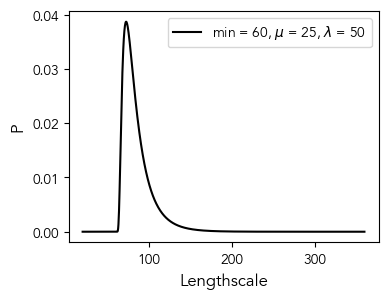

In [4]:
# visualize prior for the RBF kernel lengthscale hyperparameter

fig = plt.figure(figsize = (4, 3))

x = np.linspace(-40, 300, 1000)
ls_mins = [60]
mus = [25]
lams = [50]

for ls_min, mu, lam in zip(ls_mins, mus, lams):
    pdf = st.invgauss.pdf(x, mu/lam, scale=lam)
    plt.plot(x + ls_min, pdf, color = 'k', label=fr'min = {ls_min}, $\mu$ = {mu}, $\lambda$ = {lam}')
plt.xlabel('Lengthscale', fontsize=12)
plt.ylabel('P', fontsize=12)

plt.legend(loc=1)
plt.show()

### Per-section offset prior

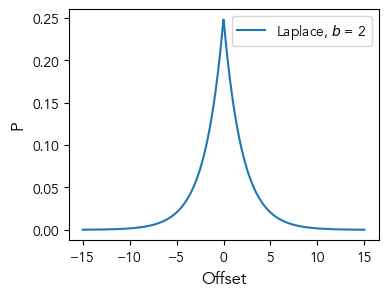

In [5]:
# offset - laplace distribution 
fig = plt.figure(figsize = (4, 3))

test = -15
x = np.linspace(-15, 15, 1000)
mus = [0] # location 
bs =[2] # scale 

for mu, b in zip(mus, bs):
    pdf = st.laplace.pdf(x, loc=mu, scale=b)
    plt.plot(x, pdf, label=r'Laplace, $b$ = {}'.format(b))
    
plt.xlabel('Offset', fontsize=12)
plt.ylabel('P', fontsize=12)

plt.legend(loc=1)
plt.show()

### Build the model

In [ ]:
# enforce superposition within the Labrador Trough (sections are through different formations, but have the same min/max ages)
superposition_dict = {}

denault_sections = ['ML1801', 'ML1809']
lefer_sections = ['ML1803', 'ML1804', 'ML1805', 'ML1807', 'ML1808']

for section in denault_sections: 
    superposition_dict[section] = lefer_sections

for section in lefer_sections: 
    superposition_dict[section] = ['Seward and Pistolet Groups']
        
model, gp = stratmc.model.build_model(
                                    sample_df_downsampled,
                                    ages_df,
                                    sections = include_sections,
                                    proxies=["d13c"],
                                    ls_dist= "Wald",
                                    ls_min=60,  # minimum RBF kernel lengthscale
                                    ls_mu=25,  # mean of Wald distribution used as RBF kernel lengthscale prior
                                    ls_lambda=50,  # lambda of Wald distribution used as RBF kernel lengthscale prior
                                    offset_type="section",  # per-section offset with default prior (Laplace, b = 2)
                                    offset_mu = 0, 
                                    offset_b = 2, 
                                    noise_type="section",  # per-section noise with default prior (HalfCauchy, beta = 1)
                                    noise_prior='HalfCauchy', 
                                    superposition_dict = superposition_dict
                                )

## Sample the posterior
To load the results for the inferences used to produce Fig. 2a, skip to [Load the inference results](#Load-the-inference-results). 

In [ ]:
## flag for large models -- required to compile on MacOS; on other operating systems, leave commented out
# pytensor.config.gcc__cxxflags = '-fbracket-depth=1024' 

# vector of ages at which to evaluate the proxy sigal
age_min = 1800 
age_max = 2600 

step = 1
predict_ages = np.arange(age_min, age_max + step, step)[:,None]

extension = "paleoproterozoic_d13C_inference"

full_trace = stratmc.inference.get_trace(
                                        model,
                                        gp,
                                        predict_ages,
                                        sample_df_downsampled,
                                        ages_df,
                                        sections = include_sections, 
                                        proxies=["d13c"],
                                        name=extension,
                                        chains=8, # update number of chains based on CPU resources (recommended 1 per core)
                                        draws=1000, 
                                        tune=2000,
                                        target_accept=0.9,
                                        save=True,
                                        sample_predictive = True
                                    )

## Load the inference results
The posterior is comprised of 101 independent Markov chains; results from different runs were combined in a single NetCDF file (available in the supplementary information):

In [6]:
full_trace = stratmc.data.load_trace("traces/" + "paleoproterozoic_d13C_trace")

## Posterior stability

In [7]:
## compute stability metrics

# variance of the RBF kernel lengthscale hyperparameter
gp_ls_variance = stratmc.inference.calculate_lengthscale_stability(full_trace, proxy = 'd13c')

# residuals between proxy signal for n vs all chains
median_residuals = stratmc.inference.calculate_proxy_signal_stability(full_trace, proxy = 'd13c')

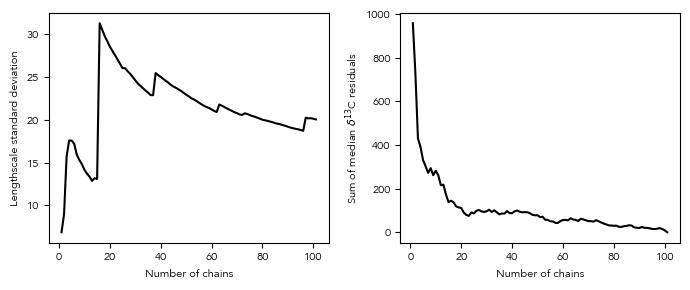

In [8]:
# stability figure for supplement 
fs = 8

fig, ax = plt.subplots(1, 2, sharex = True, sharey = False, figsize = (7, 3)) 

ax[0].plot(np.arange(len(gp_ls_variance)) + 1, gp_ls_variance, color = 'k')

ax[0].set_xlabel('Number of chains', fontsize = fs)
ax[0].set_ylabel('Lengthscale standard deviation', fontsize = fs)

ax[0].tick_params(labelsize = fs)

ax[1].plot(np.arange(median_residuals.shape[0]) + 1, np.sum(median_residuals, axis = 1), color = 'k')

ax[1].set_xlabel('Number of chains', fontsize = fs)
ax[1].set_ylabel(r'Sum of median $\delta^{13}$C residuals', fontsize = fs)

ax[1].tick_params(labelsize = fs)


fig.tight_layout()

file = 'FigS37'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)


## Plot the results
Use built-in functions to visualize the inference results. Additional metrics can be explored using the `stratmc.plotting` submodule (see the StratMC documentation: (https://stratmc.readthedocs.io/en/v1.0.0/plotting.html)

### d13C inference

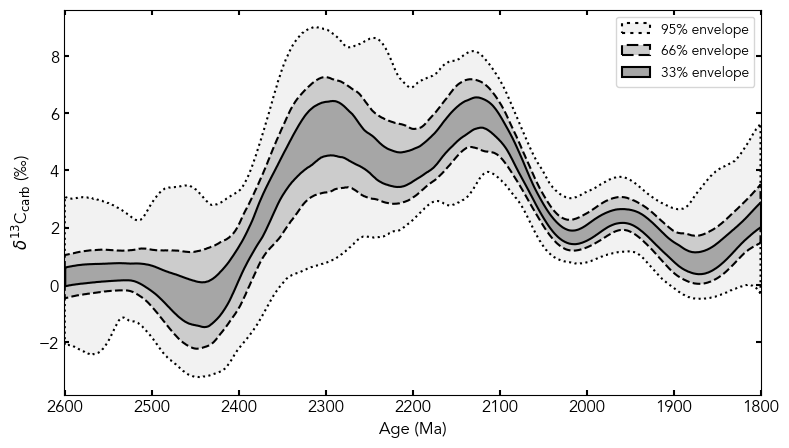

In [9]:
fig = stratmc.plotting.proxy_inference(sample_df_downsampled, ages_df, full_trace,  sections = include_sections, plot_samples=False, plot_excluded_samples = False)


### Section age models

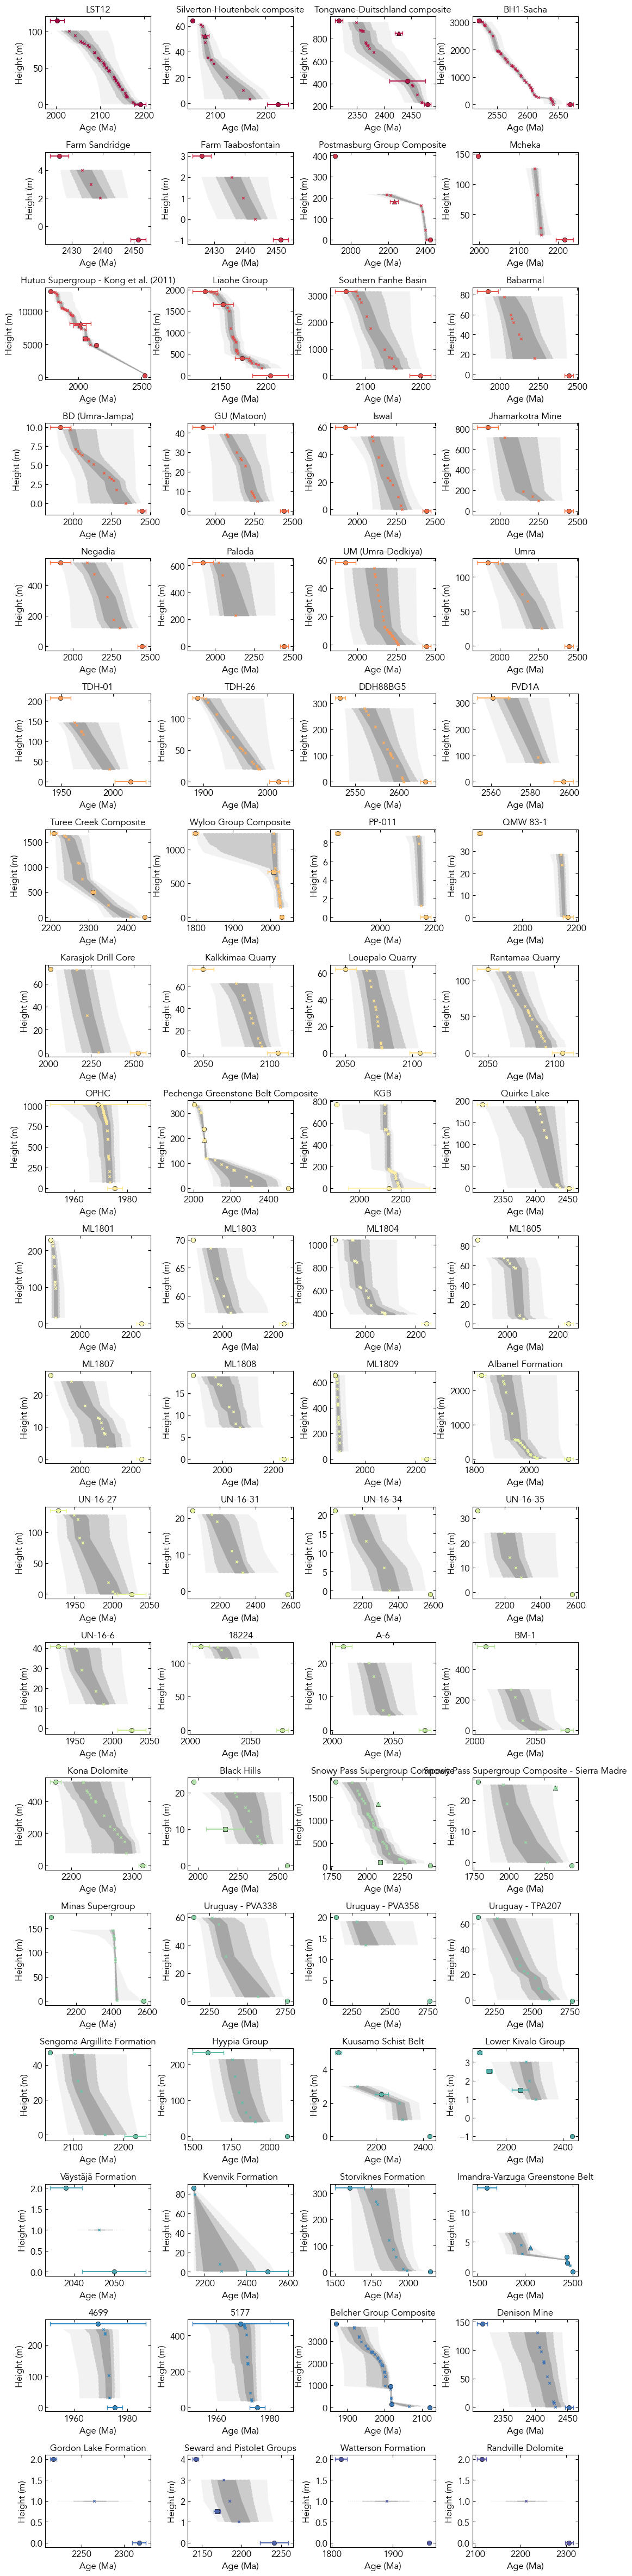

In [6]:
fig = stratmc.plotting.age_height_model(sample_df_downsampled, 
                                        ages_df, 
                                        full_trace, 
                                        sections = include_sections, 
                                       include_excluded_samples = False)

### Per-section noise and offset terms

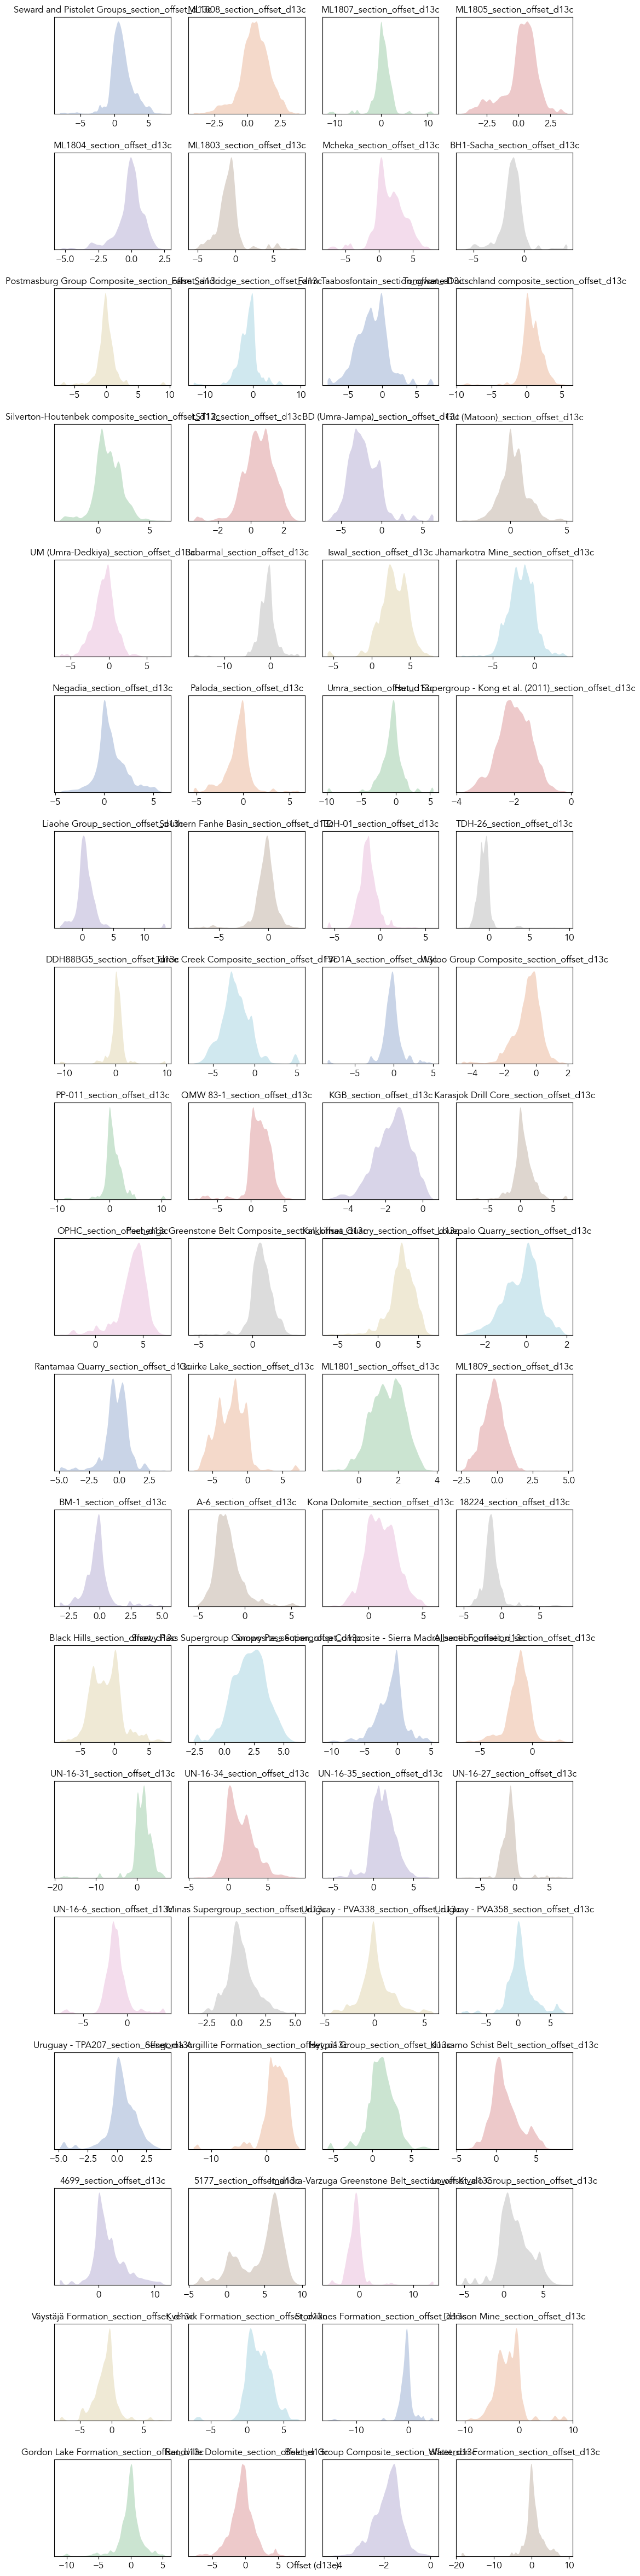

In [7]:
fig = stratmc.plotting.offset_summary(full_trace)

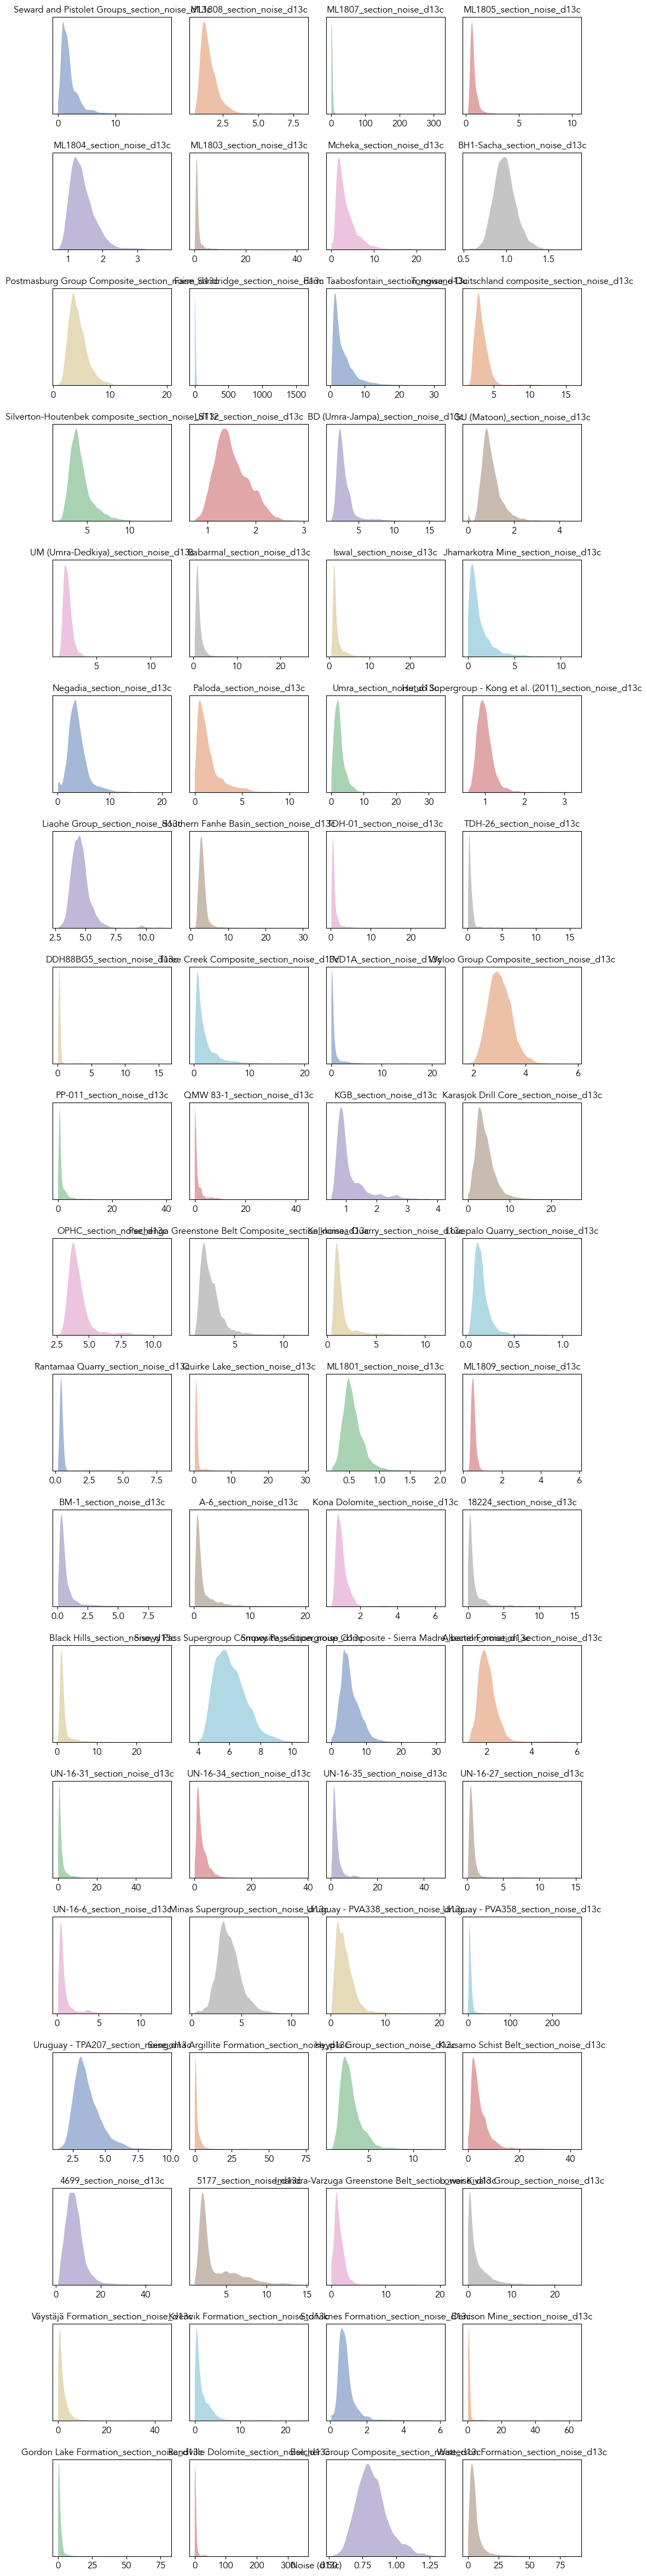

In [8]:
fig = stratmc.plotting.noise_summary(full_trace)